In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [5]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

- plot

In [6]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [7]:
def choose_plot_grid(n:int,r_max=8,c_max=17):
    rs = np.sqrt(n)
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where(res==np.min(res))
    #TODO : if len(min_idx) > 1 : minimize abs(sppt-col_nums), col_nums
    return sppt[min_idx[0]], col_nums[min_idx[0]]


def plot_feat_hue(data:pd.DataFrame,hue_label_dict=None):
    num_r, num_c = choose_plot_grid(len(data))
    fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=True,sharey=True)
    for n,ax in enumerate(axes.flatten()):
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        sns.barplot(x=data.iloc[n].index, y = data.iloc[n].values,ax =ax)
        feat_name = data.index[n]
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)

    pass

## LOAD DATA

In [8]:
pvtb_name = 'pvtb_city_entire_ver0.csv'


pvtb_path = os.path.join(pvtb_dir,pvtb_name)
pvtb_entire = pd.read_csv(pvtb_path)

pvtb_entire

geo_label_city  date_label strata_race_label strata_sex_label  \
0            Austin        2010               All             Both   
1            Austin        2010               All           Female   
2            Austin        2010               All             Male   
3            Austin        2010          Asian/PI             Both   
4            Austin        2010          Asian/PI           Female   
...             ...         ...               ...              ...   
7275     Washington        2022          Hispanic             Male   
7276     Washington        2022           Natives             Both   
7277     Washington        2022             White             Both   
7278     Washington        2022             White           Female   
7279     Washington        2022             White             Male   

      Active Transportation | Riding Bike to Work  \
0                                        1.458997   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
7275                                          NaN   
7276                                          NaN   
7277                                          NaN   
7278                                          NaN   
7279                                          NaN   

      Active Transportation | Walking to Work  \
0                                    2.506039   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
7275                                      NaN   
7276                                 8.766234   
7277                                14.201808   
7278                                      NaN   
7279                                      NaN   

      Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
0                                  2.191781                         25.479452   
1                                       NaN                               NaN   
2                                       NaN                               NaN   
3                                       NaN                               NaN   
4                                       NaN                               NaN   
...                                     ...                               ...   
7275                                    NaN                               NaN   
7276                                    NaN                               NaN   
7277                                    NaN                               NaN   
7278                                    NaN                               NaN   
7279                                    NaN                               NaN   

      Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
0                                    NaN                  7.836414  ...   
1                                    NaN                       NaN  ...   
2                                    NaN                       NaN  ...   
3                                    NaN                  8.785406  ...   
4                                    NaN                       NaN  ...   
...                                  ...                       ...  ...   
7275                                 NaN                       NaN  ...   
7276                                 NaN                       NaN  ...   
7277                                 NaN                  5.574537  ...   
7278                                 NaN                       NaN  ...   
7279                                 NaN                       NaN  ...   

      Substance Use | Adult Smoking  Substance Use | Drug Overdo

<AxesSubplot: >

/home/doeun/anaconda3/envs/EST_NA/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/EST_NA/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


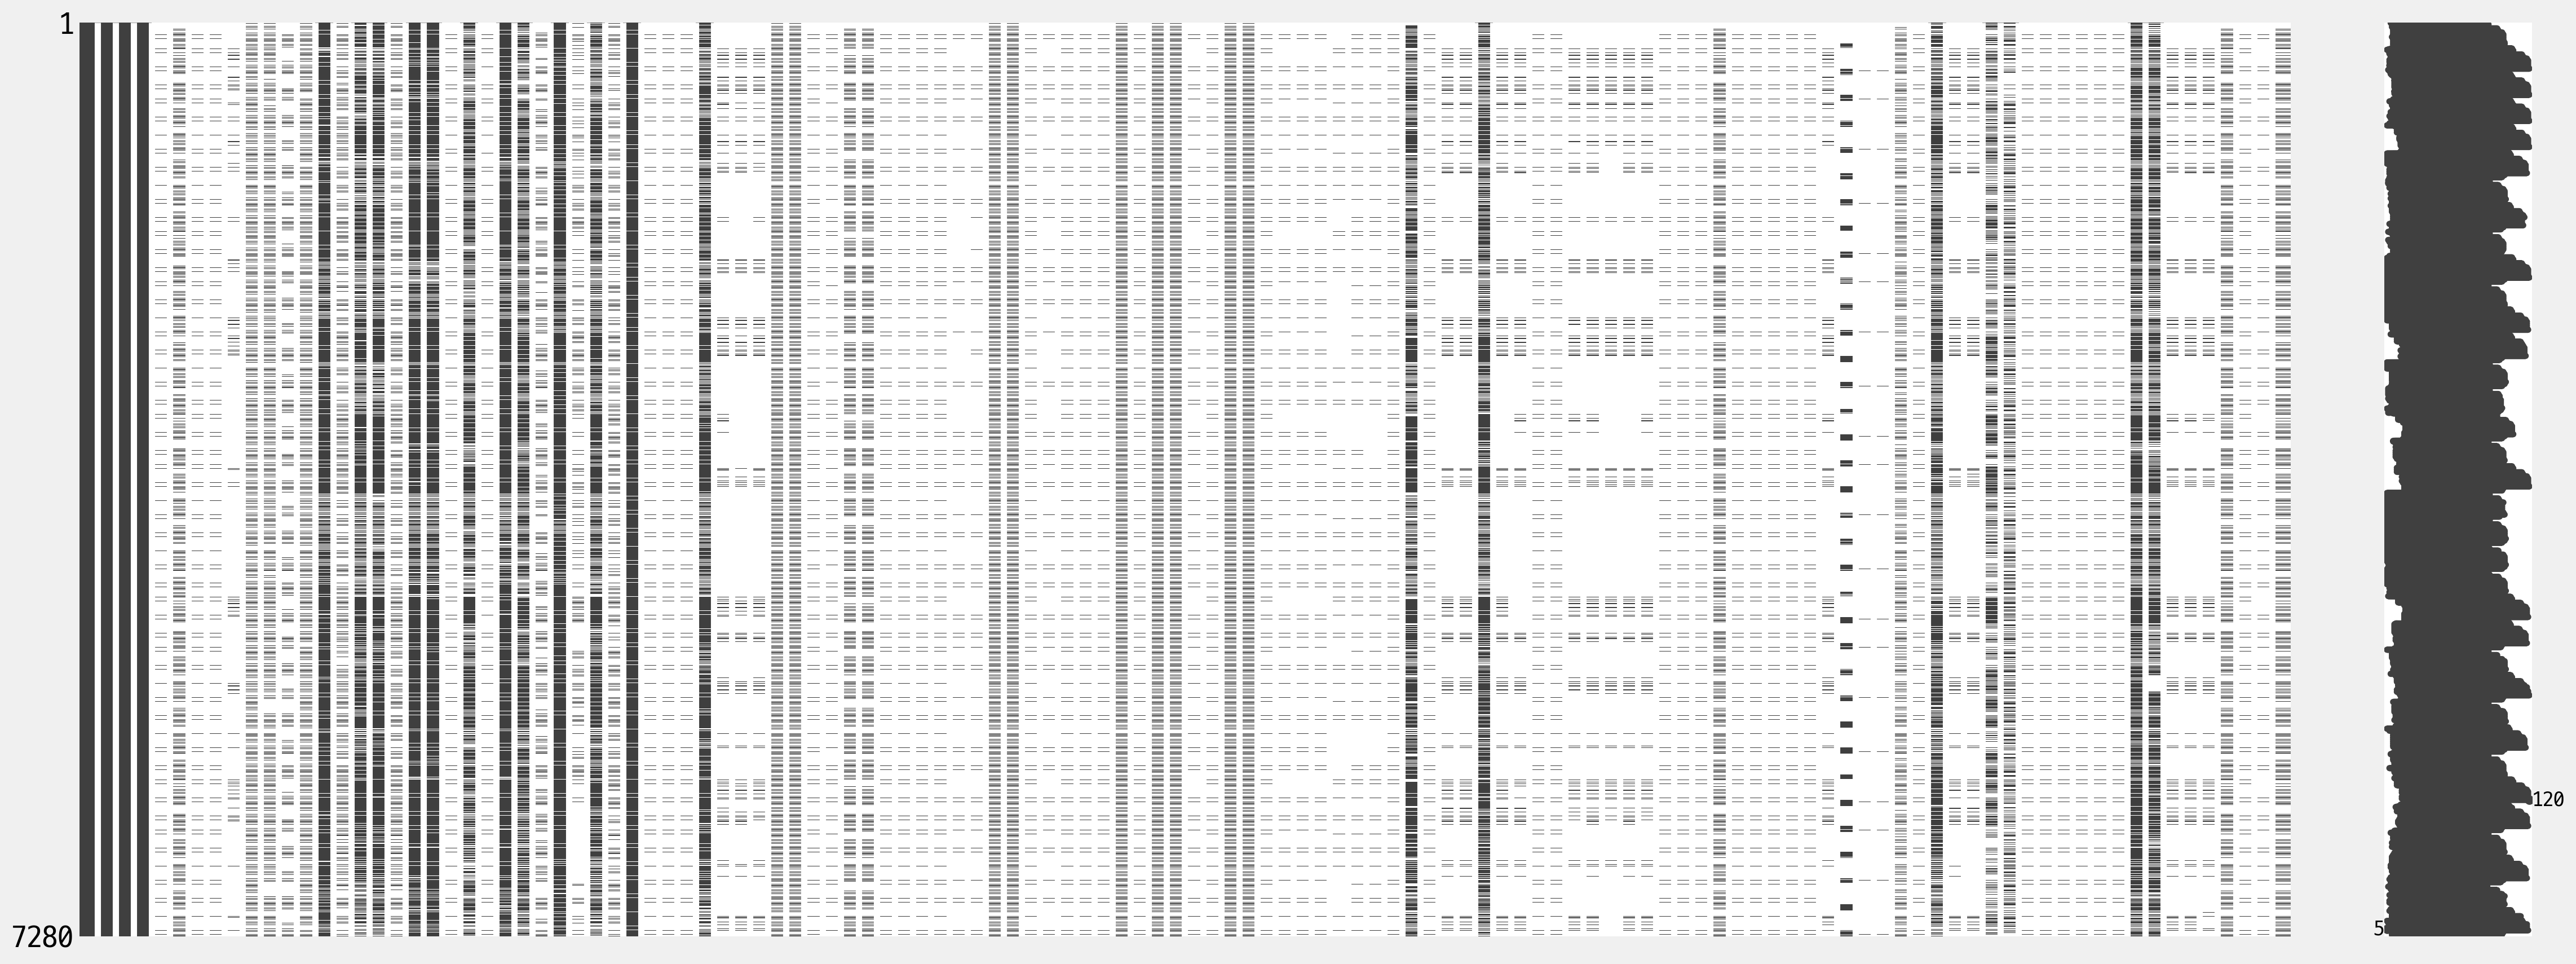

In [9]:
msno.matrix(pvtb_entire)

<AxesSubplot: >

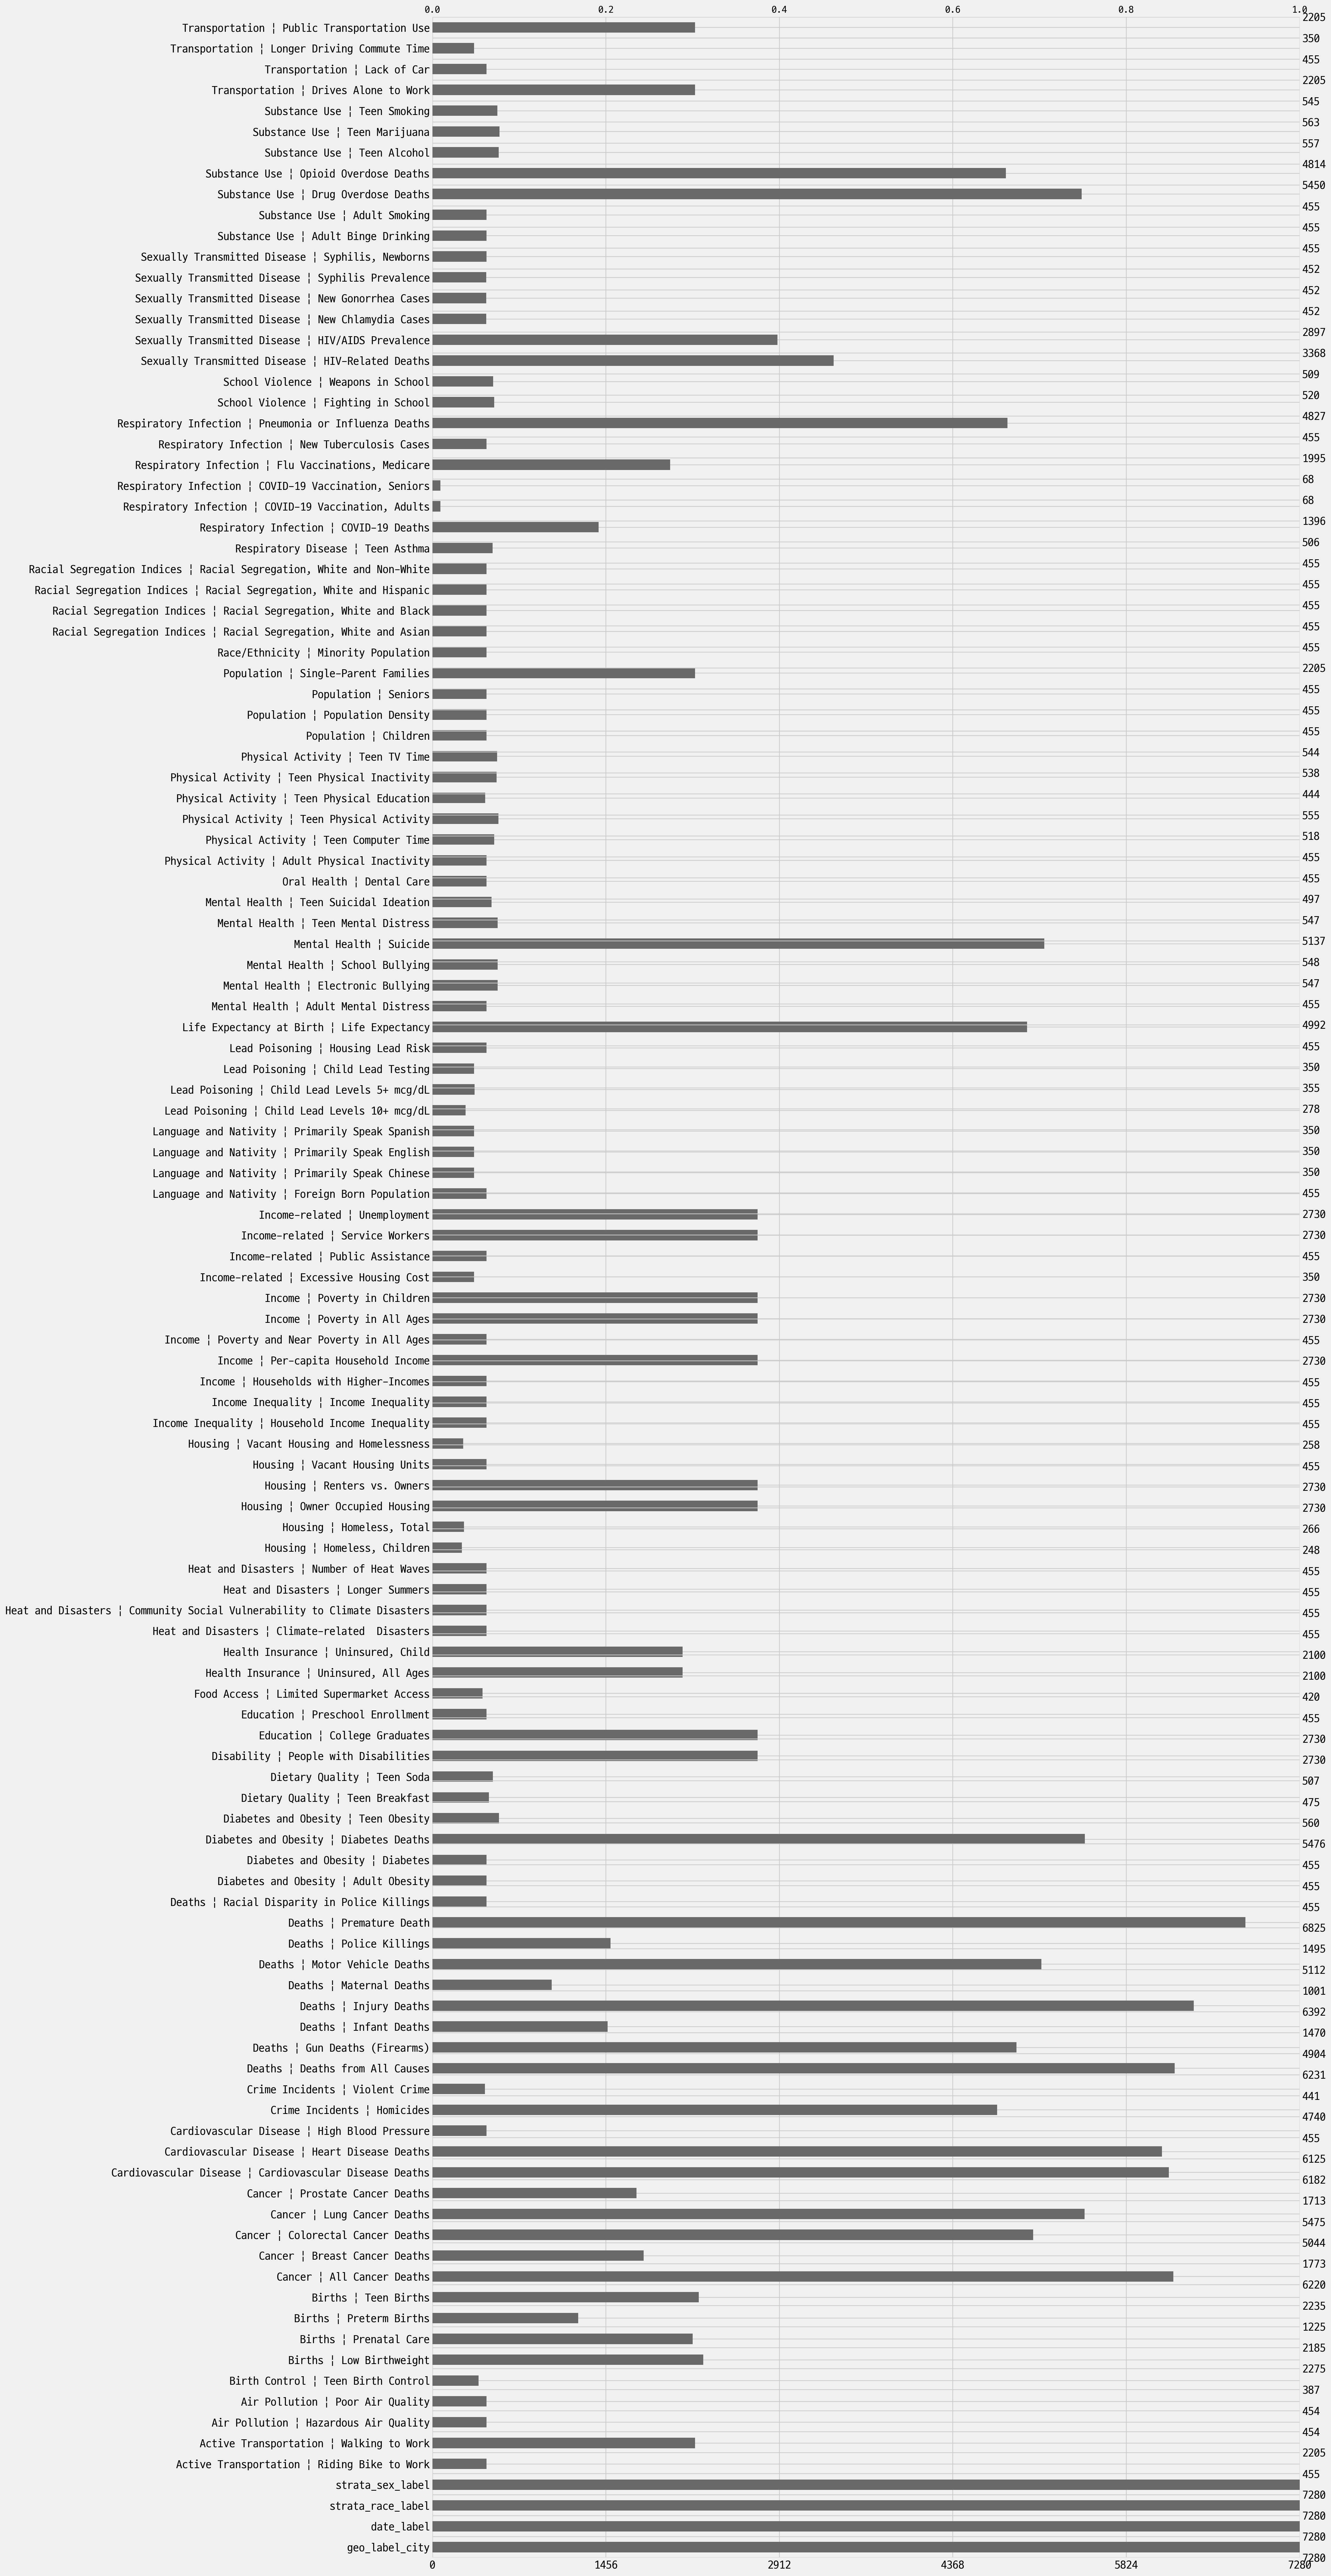

In [10]:
msno.bar(pvtb_entire)

<AxesSubplot: >

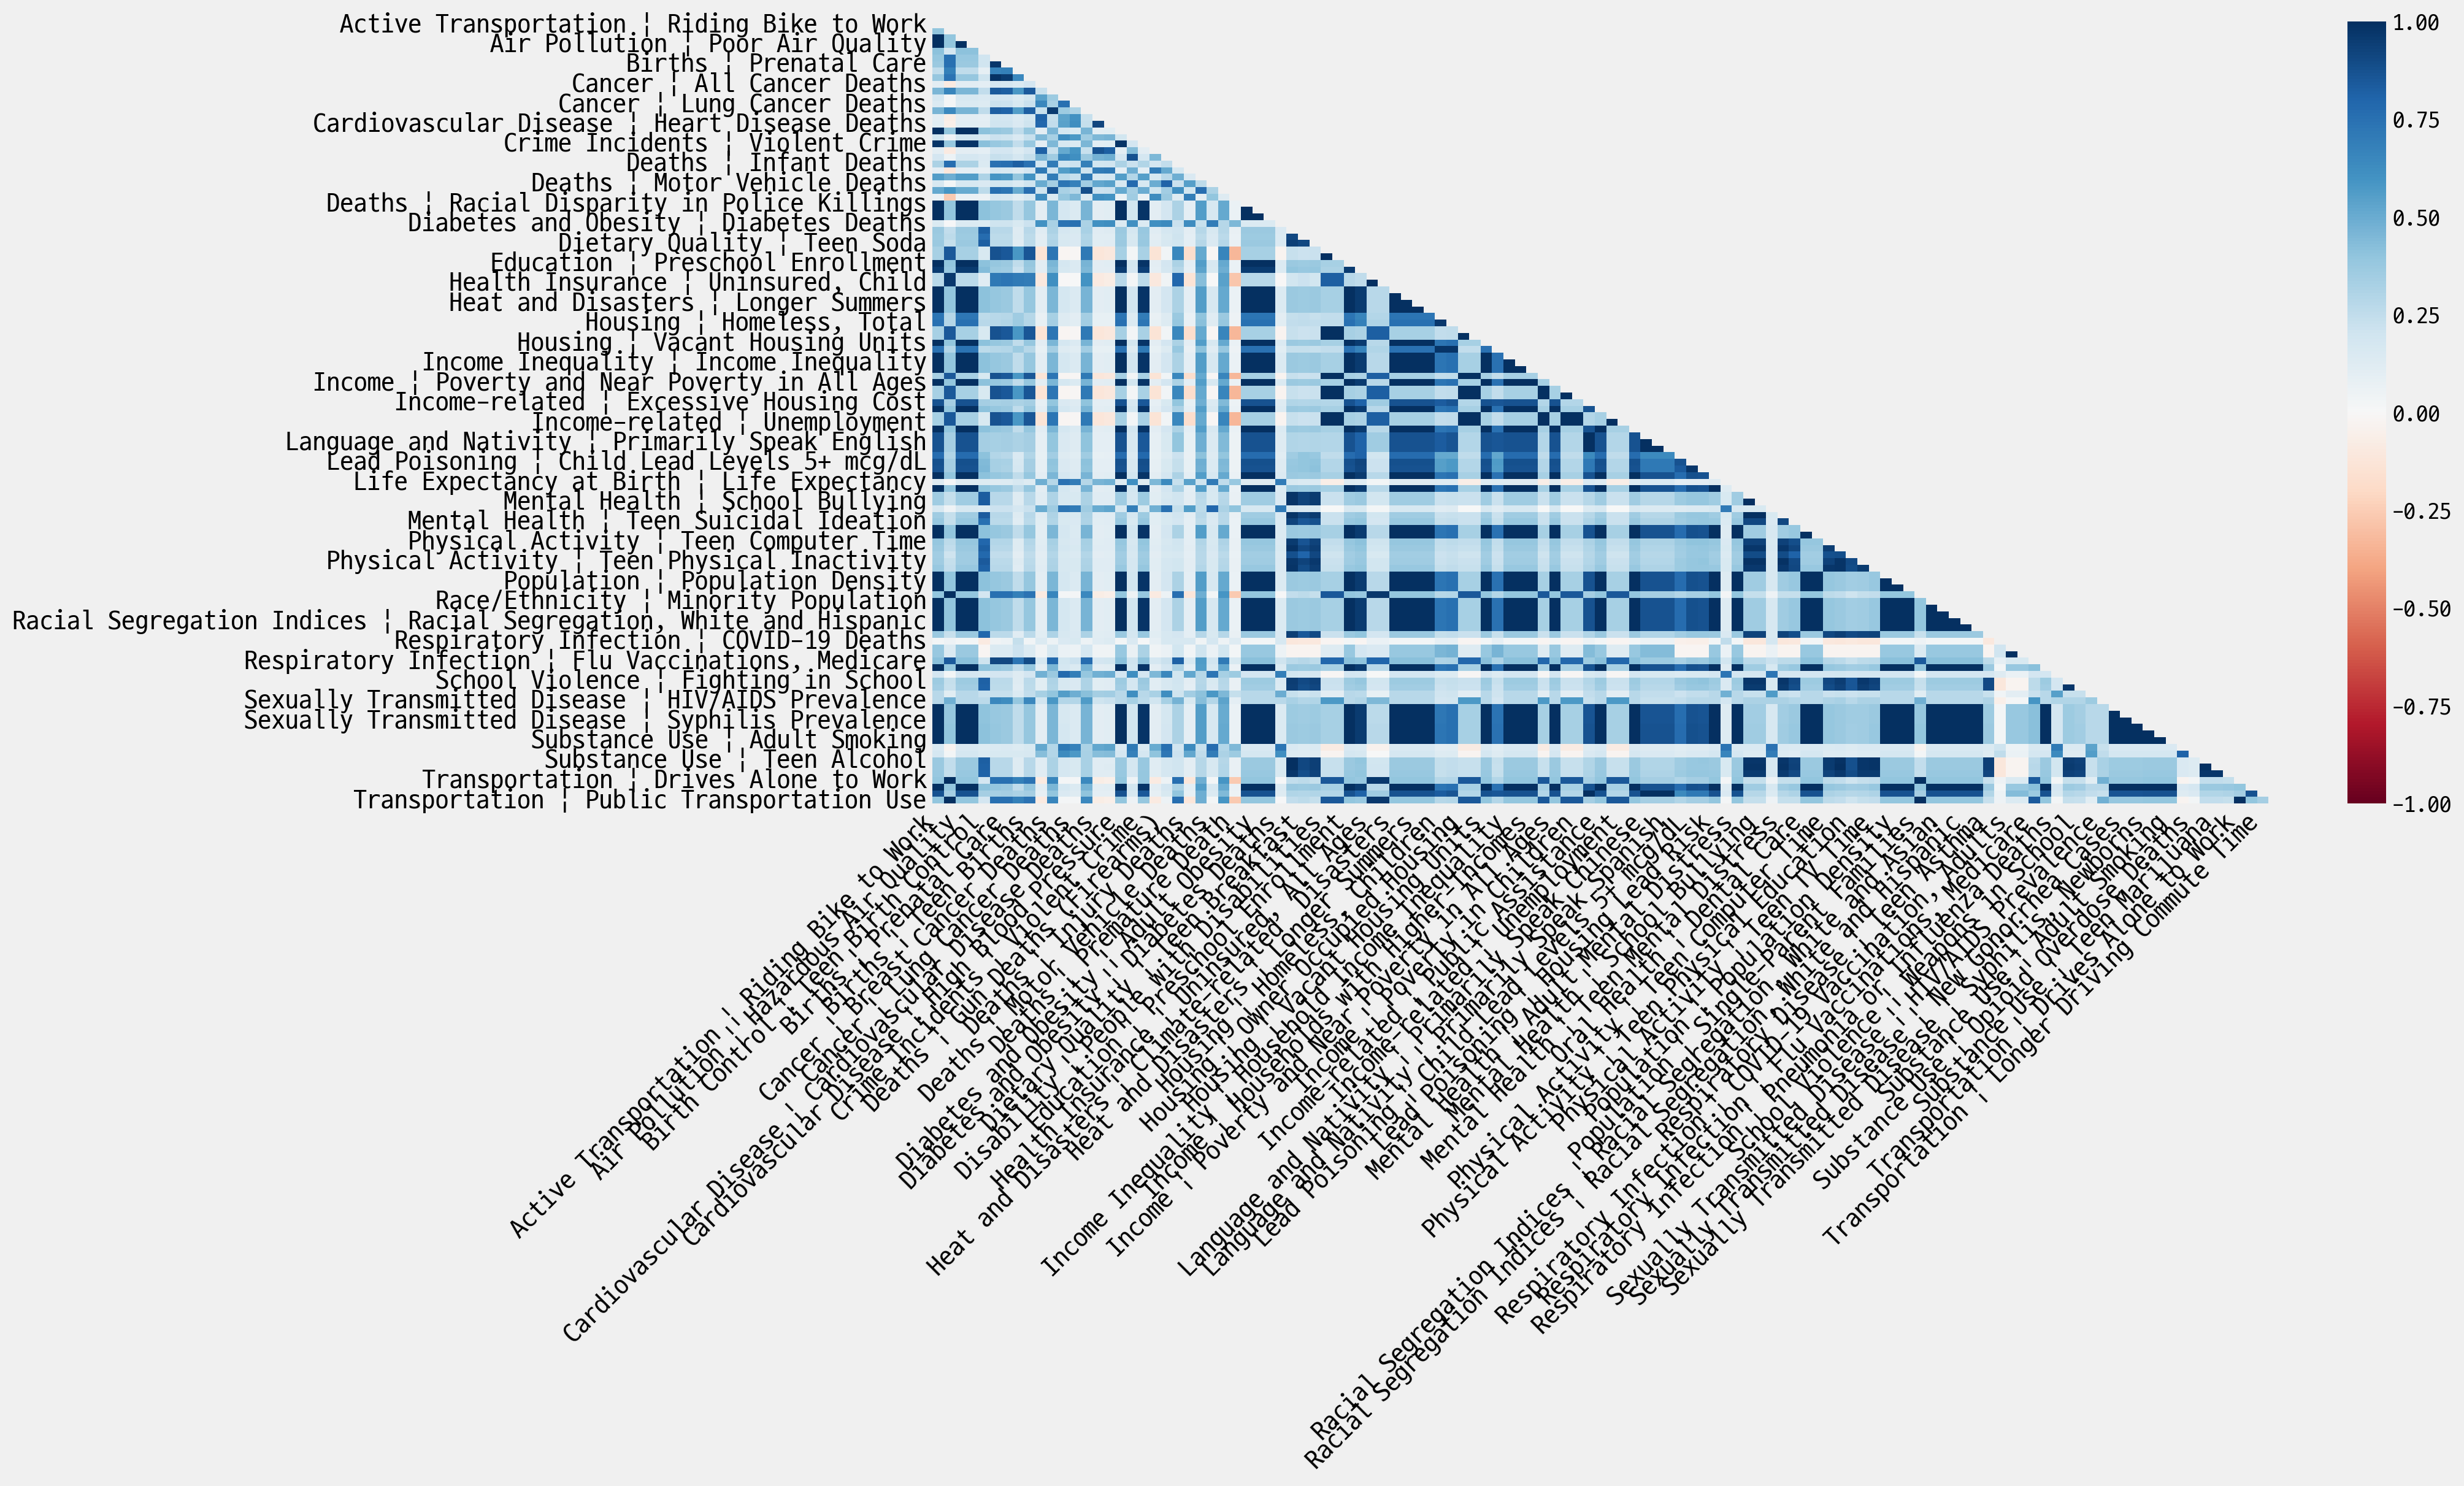

In [11]:
msno.heatmap(pvtb_entire, labels=False)

<AxesSubplot: >

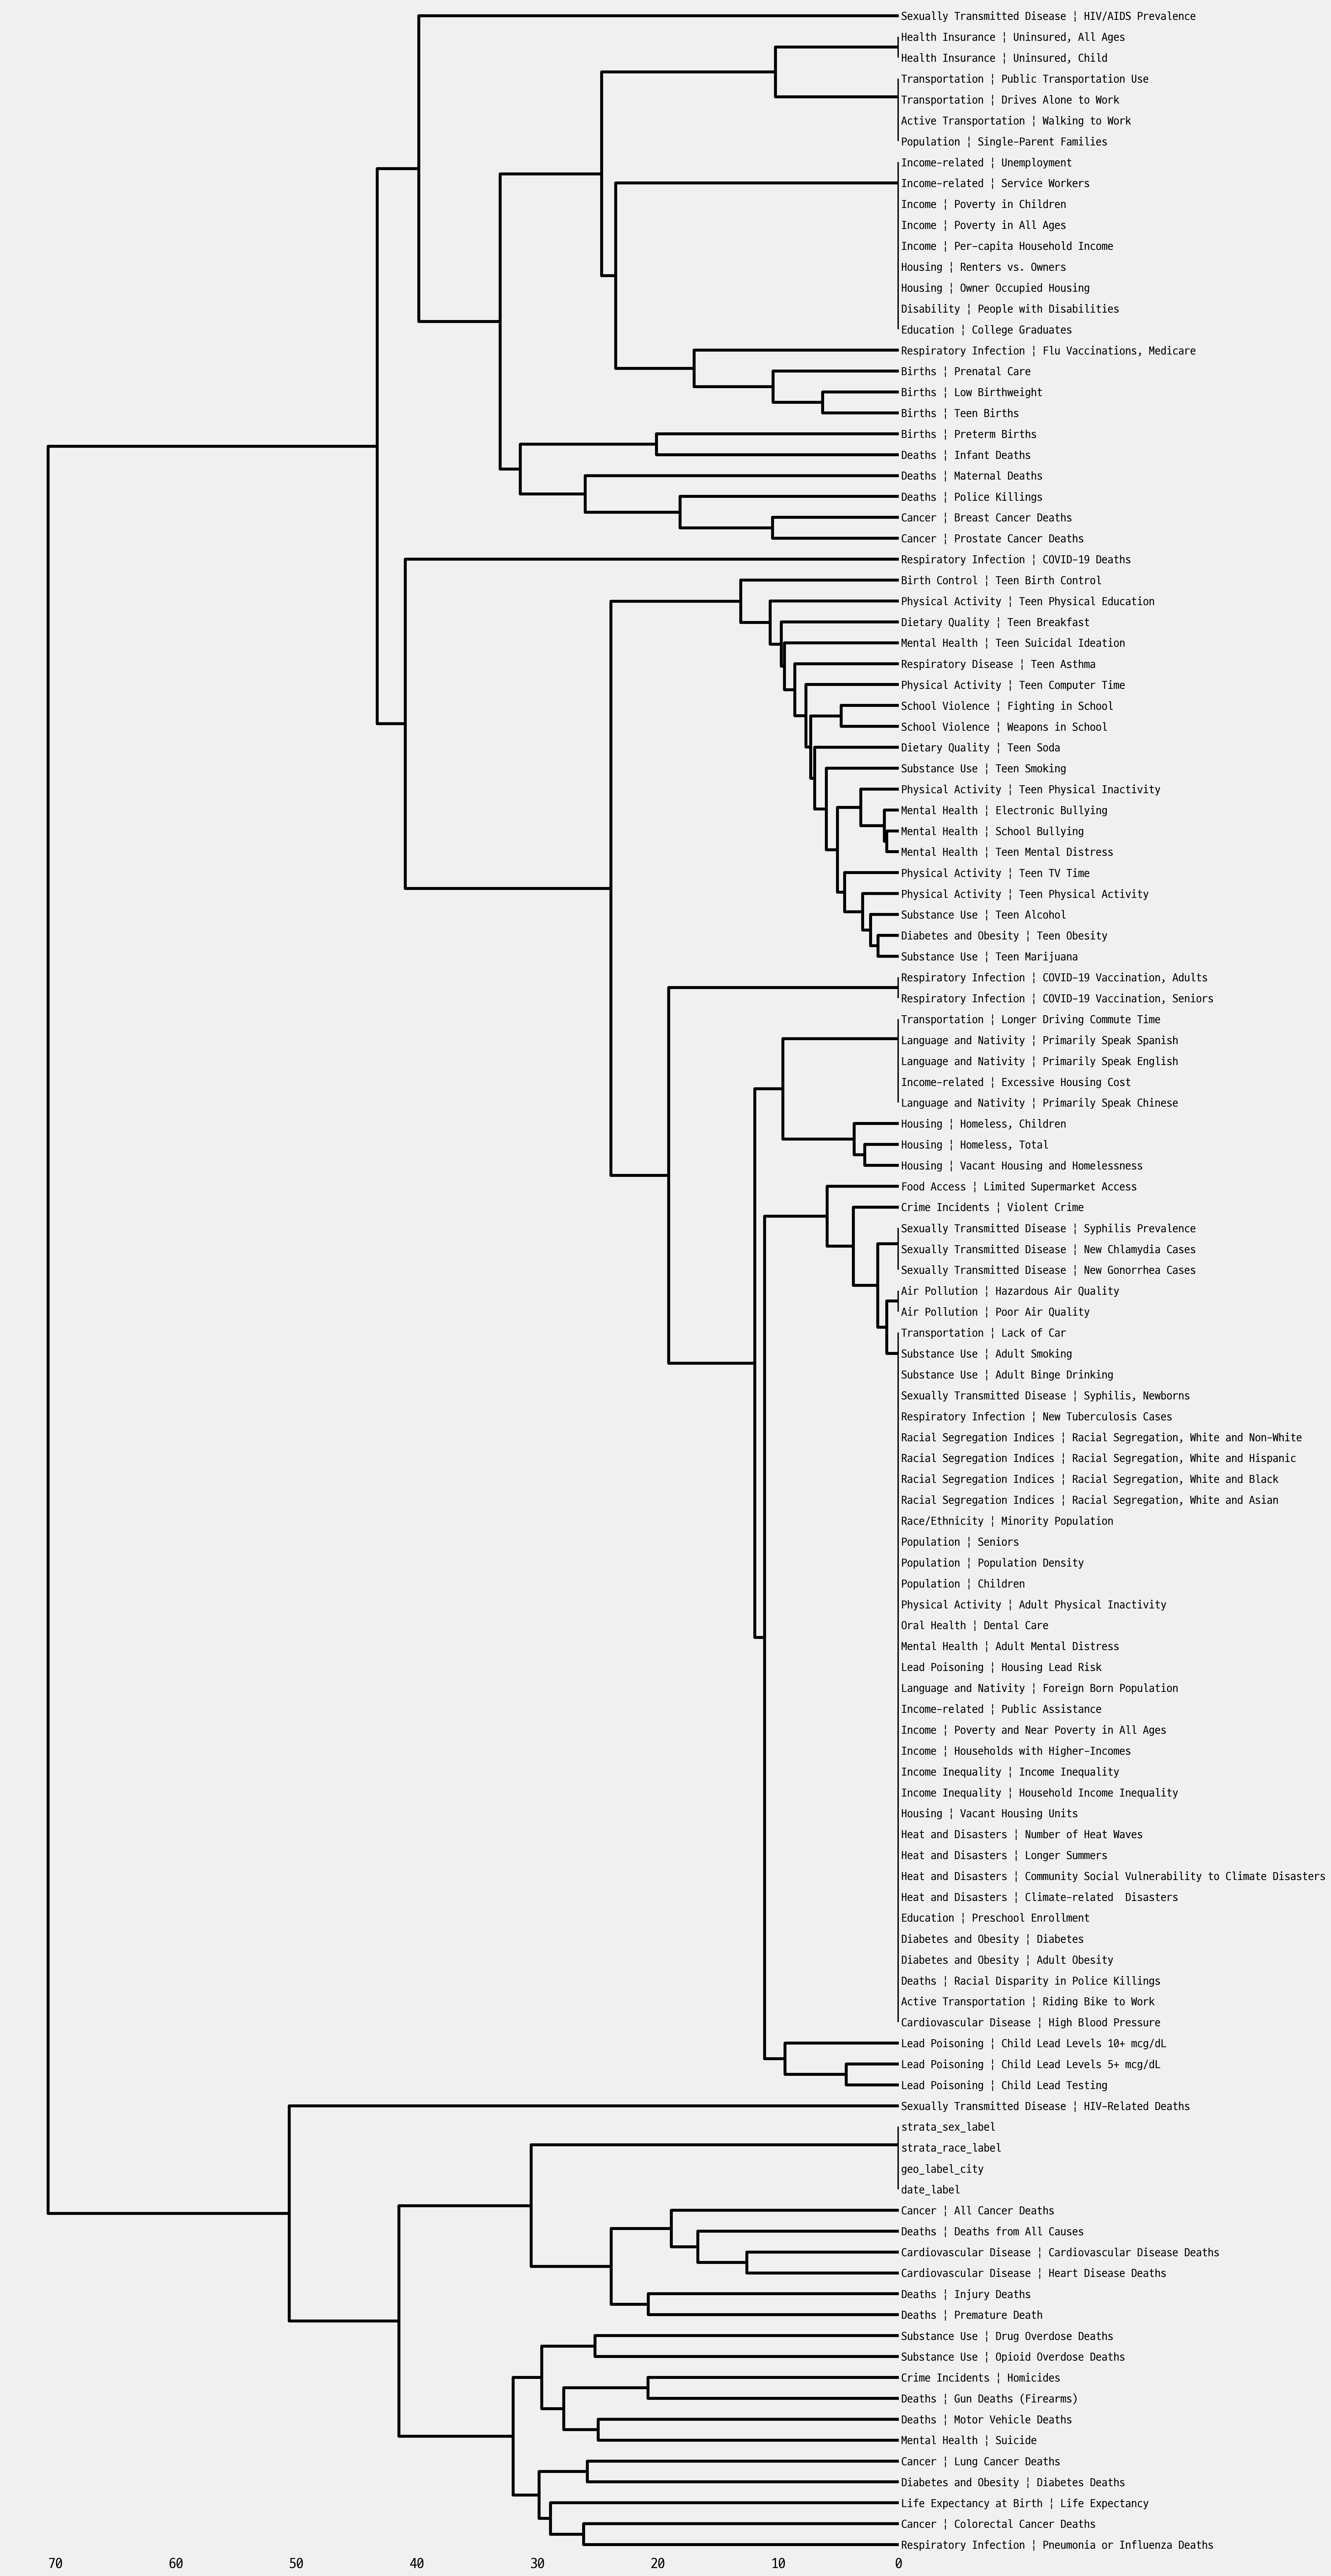

In [12]:
msno.dendrogram(pvtb_entire)

In [13]:
labels = pvtb_entire.columns[4:]

np.sum(~pvtb_entire[labels].isna(),axis=0)

Active Transportation | Riding Bike to Work      455
Active Transportation | Walking to Work         2205
Air Pollution | Hazardous Air Quality            454
Air Pollution | Poor Air Quality                 454
Birth Control | Teen Birth Control               387
                                                ... 
Substance Use | Teen Smoking                     545
Transportation | Drives Alone to Work           2205
Transportation | Lack of Car                     455
Transportation | Longer Driving Commute Time     350
Transportation | Public Transportation Use      2205
Length: 118, dtype: int64

### filter label that almost filled

1. entire 기준으로 80% 이상 있는 label이 뭐가 있는지 확인
2. total 기준 전부 다 있는 label이 entire 기준으로는 어느정도 있는지 확인

In [30]:
pvtb_entire_T = pvtb_entire.T
(pvtb_entire_T[np.sum(pvtb_entire_T.isna(),axis=1) < 7280 * 0.2].index)

Index(['geo_label_city', 'date_label', 'strata_race_label', 'strata_sex_label',
       'Cancer | All Cancer Deaths',
       'Cardiovascular Disease | Cardiovascular Disease Deaths',
       'Cardiovascular Disease | Heart Disease Deaths',
       'Deaths | Deaths from All Causes', 'Deaths | Injury Deaths',
       'Deaths | Premature Death'],
      dtype='object')

In [31]:
pvtb_entire_T = pvtb_entire.T
(pvtb_entire_T[np.sum(pvtb_entire_T.isna(),axis=1) < 7280 * 0.25].index)

Index(['geo_label_city', 'date_label', 'strata_race_label', 'strata_sex_label',
       'Cancer | All Cancer Deaths', 'Cancer | Lung Cancer Deaths',
       'Cardiovascular Disease | Cardiovascular Disease Deaths',
       'Cardiovascular Disease | Heart Disease Deaths',
       'Deaths | Deaths from All Causes', 'Deaths | Injury Deaths',
       'Deaths | Premature Death', 'Diabetes and Obesity | Diabetes Deaths'],
      dtype='object')

In [32]:
pvtb_entire_T = pvtb_entire.T
(pvtb_entire_T[np.sum(pvtb_entire_T.isna(),axis=1) < 7280 * 0.3].index)

Index(['geo_label_city', 'date_label', 'strata_race_label', 'strata_sex_label',
       'Cancer | All Cancer Deaths', 'Cancer | Lung Cancer Deaths',
       'Cardiovascular Disease | Cardiovascular Disease Deaths',
       'Cardiovascular Disease | Heart Disease Deaths',
       'Deaths | Deaths from All Causes', 'Deaths | Injury Deaths',
       'Deaths | Motor Vehicle Deaths', 'Deaths | Premature Death',
       'Diabetes and Obesity | Diabetes Deaths', 'Mental Health | Suicide',
       'Substance Use | Drug Overdose Deaths'],
      dtype='object')

In [16]:
pvtb_entire_T

0       1       2     \
geo_label_city                                   Austin  Austin  Austin   
date_label                                         2010    2010    2010   
strata_race_label                                   All     All     All   
strata_sex_label                                   Both  Female    Male   
Active Transportation | Riding Bike to Work    1.458997     NaN     NaN   
...                                                 ...     ...     ...   
Substance Use | Teen Smoking                        NaN     NaN     NaN   
Transportation | Drives Alone to Work         71.701852     NaN     NaN   
Transportation | Lack of Car                   7.104797     NaN     NaN   
Transportation | Longer Driving Commute Time        NaN     NaN     NaN   
Transportation | Public Transportation Use     4.673879     NaN     NaN   

                                                  3         4         5     \
geo_label_city                                  Austin    Austin    Austin   
date_label                                        2010      2010      2010   
strata_race_label                             Asian/PI  Asian/PI  Asian/PI   
strata_sex_label                                  Both    Female      Male   
Active Transportation | Riding Bike to Work        NaN       NaN       NaN   
...                                                ...       ...       ...   
Substance Use | Teen Smoking                       NaN       NaN       NaN   
Transportation | Drives Alone to Work              NaN       NaN       NaN   
Transportation | Lack of Car                       NaN       NaN       NaN   
Transportation | Longer Driving Commute Time       NaN       NaN       NaN   
Transportation | Public Transportation Use         NaN       NaN       NaN   

                                                6       7       8     \
geo_label_city                                Austin  Austin  Austin   
date_label                                      2010    2010    2010   
strata_race_label                              Black   Black   Black   
strata_sex_label                                Both  Female    Male   
Active Transportation | Riding Bike to Work      NaN     NaN     NaN   
...                                              ...     ...     ...   
Substance Use | Teen Smoking                     NaN     NaN     NaN   
Transportation | Drives Alone to Work            NaN     NaN     NaN   
Transportation | Lack of Car                     NaN     NaN     NaN   
Transportation | Longer Driving Commute Time     NaN     NaN     NaN   
Transportation | Public Transportation Use       NaN     NaN     NaN   

                                                  9     ...        7270  \
geo_label_city                                  Austin  ...  Washington   
date_label                                        2010  ...        2022   
strata_race_label                             Hispanic  ...       Black   
strata_sex_label                                  Both  ...        Both   
Active Transportation | Riding Bike to Work        NaN  ...         NaN   
...                                                ...  ...         ...   
Substance Use | Teen Smoking                       NaN  ...         NaN   
Transportation | Drives Alone to Work              NaN  ...   40.725046   
Transportation | Lack of Car                       NaN  ...         NaN   
Transportation | Longer Driving Commute Time       NaN  ...         NaN   
Transportation | Public Transportation Use         NaN  ...   28.420494   

                                                    7271        7272  \
geo_label_city                                Washington  Washington   
date_label                                          2022        2022   
strata_race_label                                  Black       Black   
strata_sex_label                                  Female        Male   
Active Transportation | Riding Bike to Work          NaN         NaN   
...            

### 결측치 확인
- 연도/도시 기준으로 결측률
    1. 하나의 데이터라도 있는지가 기준
    2. All-Both가 있는지를 기준
   - stratification data 만을 기준으로 결측률 확인
    3. All, Both 제외 하나라도 있으면 있는 것 기준
    4. All, Both 제외 두 개 이상 있는 것 기준
    5. 전체 race-sex에서 ths 이상 있는 것 기준
        - ths = 0.5, 0.7

1. 각 label 별로 7*17 에 plot
    - count/ ratio
2. y축 label, x축 연도로 해서 plot
    - 이 경우 ratio를 기준으로 색을 할 수 있을 것 같음
        - 도시 별로 집계한 것을 다시 집계하는 것은 큰 의미가 없을 듯
    - heatmap으로 그리면 될 듯 
3. y축 label, x축 도시로 해서 plot
    - 도시간 정렬은 records 양 순서대로
4. (2와 3통합)

In [15]:
pvtb_entire['geo_label_city'].value_counts()

geo_label_city
Austin           208
Phoenix          208
Milwaukee        208
Minneapolis      208
New York City    208
Oakland          208
Oklahoma City    208
Philadelphia     208
Portland         208
Louisville       208
San Antonio      208
San Diego        208
San Francisco    208
San Jose         208
Seattle          208
Tucson           208
Memphis          208
Los Angeles      208
Baltimore        208
Denver           208
Boston           208
Charlotte        208
Chicago          208
Cleveland        208
Columbus         208
Dallas           208
Detroit          208
Long Beach       208
El Paso          208
Fort Worth       208
Houston          208
Indianapolis     208
Kansas City      208
Las Vegas        208
Washington       208
Name: count, dtype: int64

- 각 (인종,성별,도시,연도) tuple 별로 각 라벨에서의 데이터 값에 대해서 sppt에서의 거리와 label value에서의 거리 사이에 비교
    - sppt 에서의 metric
        - 각각의 차원에서의 거리를 규정한 뒤, 각 차원에서의 거리를 euclidean
            - 각각의 차원에서의 거리에 붙어야 할 계수를 회귀로 구할 수 있음
            - 각각의 차원에서의 거리를 통해, 전체 차원에서의 거리를 구하는 방법을 NN으로 구할 수 있음
        - 인종, 성별 : all, both 와의 거리는 다른 집단과의 거리보다 짧게
        - 도시 : 도시에 대한 geo_strata 정보를 기준으로 metric 정의
            - geo_strata의 feature : region, poverty, population, popDensity, segration
            - 추가적으로 feature를 더한다면 : 내륙/해안/접경, 위도경도
            - geo_strata의 값이 연도 별로 달라지는 지 확인
        - 연도 : 차이